Iniciando simulación... (esto puede tardar unos minutos)
Simulando L=8...
Simulando L=10...
Gráfica 1 guardada como fig1_poisson.png
Gráfica 2 guardada como fig2_transition.png


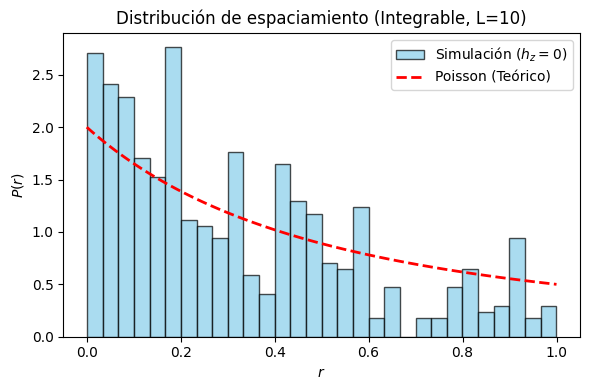

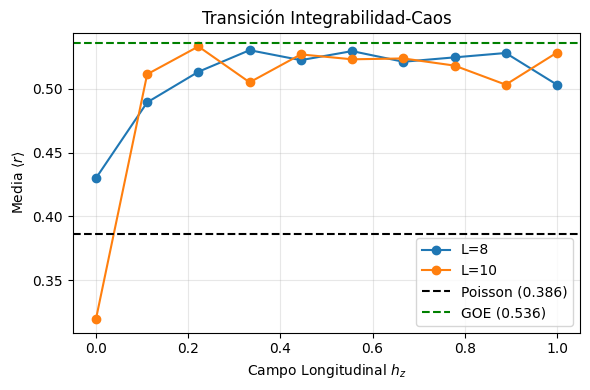

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import eigsh

def get_hamiltonian(L, J, hx, hz, pbc=False):
    """
    Construye el Hamiltoniano del modelo de Ising con campo transverso y longitudinal.
    L: número de espines
    J: constante de acoplamiento
    hx: campo transversal
    hz: campo longitudinal
    pbc: Periodic Boundary Conditions (False usa OBC para romper simetrías)
    """
    # Matrices de Pauli dispersas
    sx = sparse.csr_matrix([[0, 1], [1, 0]])
    sz = sparse.csr_matrix([[1, 0], [0, -1]])
    id2 = sparse.eye(2)

    # Función auxiliar para operador en sitio i
    def op_at_site(op, i, L):
        ops = [id2] * L
        ops[i] = op
        res = ops[0]
        for k in range(1, L):
            res = sparse.kron(res, ops[k])
        return res

    # Dimensión del espacio de Hilbert
    dim = 2**L
    H = sparse.csr_matrix((dim, dim))

    # Término de interacción: -J * sz_i * sz_{i+1}
    # Usamos OBC (Open Boundary Conditions) para romper simetría de traslación
    limit = L if pbc else L - 1
    for i in range(limit):
        j = (i + 1) % L
        J_local = J * (1 + 0.1 * np.sin(i))
        term = -J_local * (op_at_site(sz, i, L) @ op_at_site(sz, j, L))
        H += term

    # Campo transversal: -hx * sx
    for i in range(L):
        H += -hx * op_at_site(sx, i, L)

    # Campo longitudinal: -hz * sz
    for i in range(L):
        H += -hz * op_at_site(sz, i, L)

    return H

def calculate_r_stats(eigenvalues):
    """Calcula el parámetro medio r para un espectro dado"""
    e = np.sort(eigenvalues)
    s = np.diff(e)
    # Filtrar gaps numéricamente cero (degeneraciones)
    s = s[s > 1e-12]
    if len(s) < 2: return np.nan
    # Definición de r_n = min(s_n, s_{n-1}) / max(...)
    r = np.minimum(s[:-1], s[1:]) / np.maximum(s[:-1], s[1:])
    return r

# --- Parámetros de Simulación ---
L_list = [8, 10] # Tamaños del sistema
h_z_values = np.linspace(0, 1.0, 10) # Barrido del campo hz
J = 1.0
h_x = 1.0

# Almacenamiento de resultados
mean_rs = {L: [] for L in L_list}
r_dist_integrable = []

print("Iniciando simulación... (esto puede tardar unos minutos)")

# --- Bucle de Transición ---
for L in L_list:
    print(f"Simulando L={L}...")
    for hz in h_z_values:
        # Construir Hamiltoniano
        H = get_hamiltonian(L, J, hx=h_x, hz=hz, pbc=False)

        # Diagonalización Exacta (obtenemos TODOS los autovalores)
        # Convertimos a denso (.toarray()) porque L es pequeño
        vals = np.linalg.eigvalsh(H.toarray())

        # Calcular estadística
        r_vals = calculate_r_stats(vals)
        mean_rs[L].append(np.mean(r_vals))

        # Guardar distribución completa solo para el caso integrable (hz=0) del sistema más grande
        if hz == 0 and L == max(L_list):
            r_dist_integrable = r_vals

# --- Generación de Gráficas ---

# Gráfica 1: Histograma P(r) para caso Integrable
plt.figure(figsize=(6, 4))
plt.hist(r_dist_integrable, bins=30, density=True, alpha=0.7,
         color='skyblue', edgecolor='black', label='Simulación ($h_z=0$)')

# Curva teórica Poisson P(r) = 2/(1+r)^2
r_grid = np.linspace(0, 1, 100)
p_poisson = 2 / (1 + r_grid)**2
plt.plot(r_grid, p_poisson, 'r--', linewidth=2, label='Poisson (Teórico)')

plt.xlabel('$r$')
plt.ylabel('$P(r)$')
plt.title(f'Distribución de espaciamiento (Integrable, L={max(L_list)})')
plt.legend()
plt.tight_layout()
plt.savefig('fig1_poisson.png')
print("Gráfica 1 guardada como fig1_poisson.png")

# Gráfica 2: Transición de <r> vs hz
plt.figure(figsize=(6, 4))
for L in L_list:
    plt.plot(h_z_values, mean_rs[L], 'o-', label=f'L={L}')

# Líneas de referencia
plt.axhline(0.386, color='k', linestyle='--', label='Poisson (0.386)')
plt.axhline(0.536, color='g', linestyle='--', label='GOE (0.536)')

plt.xlabel('Campo Longitudinal $h_z$')
plt.ylabel('Media $\\langle r \\rangle$')
plt.title('Transición Integrabilidad-Caos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('fig2_transition.png')
print("Gráfica 2 guardada como fig2_transition.png")